In [2]:
import pandas as pd
from plotnine import (
    ggplot, geom_point, geom_line, geom_smooth, geom_bar,
    aes, facet_wrap, labs,
    scale_x_log10, scale_y_continuous, scale_y_log10,
)
import matplotlib.pyplot as plt
import patchworklib as pw
import numpy as np
from llm_ran.benchmark.metrics import pass_at, pass_power

from llm_ran.benchmark.questions import TEST_CASES

import plotnine as pn
my_theme = lambda x, y: pn.theme_classic() + pn.theme(
    # axis_text_x=pn.element_text(rotation=15, hjust=1),
    panel_grid_major_y=pn.element_line(size=0.5, color="grey"),
    panel_border=pn.element_rect(size=1, color="black"),
    figure_size=(x, y)
)

productcatalogservice-7476c969c8-5z2sn None


<Figure size 100x100 with 0 Axes>

In [3]:
QUESTIONS_META = {
    (test_case.scenario, question.id): question
    for test_case in TEST_CASES
    for question in test_case.questions
}

levels = ["Simple Fact Finding", "Complex Fact Finding", "Reasoning"]

questions = pd.DataFrame([
    {
        "scenario": test_case.scenario or "base",
        "question": question.id,
        "question_type": levels[question.level],
    }
    for test_case in TEST_CASES
    for question in test_case.questions
]).set_index(["scenario", "question"])
display(len(questions))

43

In [4]:
DATA_PATH = "../data"
OUTPUT_PATH = "../../thesis/figures"

mainline_models = [
    "qwen2.5:32b",
    "mixtral:8x22b",
    # "qwen2.5-coder:32b",
    # "sky-t1:32b",
    # "qwq:32b",
]

df = pd.read_csv(f"{DATA_PATH}/processed/combined.csv", index_col=0)
df = df[df['model'].isin(mainline_models)]
df = df.rename(columns={"chain": "agent"})
df = df.join(questions, on=["scenario", "question"])
df['question_type'] = pd.Categorical(df['question_type'], categories=levels, ordered=True)
df['model'] = pd.Categorical(df['model'], categories=mainline_models, ordered=True)

zero_to_na = ["total_tokens"]
for col in zero_to_na:
    df[col] = df[col].replace(0, np.nan)

df.columns

Index(['scenario', 'question', 'trial', 'run_id', 'model', 'agent',
       'total_trials', 'level', 'evaluate_as', 'expected', 'num_messages',
       'execution_time', 'eval_count', 'prompt_eval_count', 'eval_duration',
       'prompt_eval_duration', 'load_duration', 'total_duration',
       'total_tokens', 'max_eval_count', 'max_prompt_eval_count',
       'max_eval_duration', 'max_prompt_eval_duration', 'max_load_duration',
       'max_total_duration', 'snapshot_path', 'result', 'error', 'file',
       'can_answer', 'correct', 'pass', 'deviation', 'question_type'],
      dtype='object')

In [5]:
group_by = ["model", "agent"]
metrics = ["can_answer", "correct", 'execution_time', "total_tokens", "num_messages", "pass"]

agg1 = {
    "can_answer@5": ('can_answer', pass_at(5)),
    "can_answer@1": ('can_answer', pass_at(1)),
    "can_answer^5": ('can_answer', pass_power(5)),
    "can_answer@10": ('can_answer', pass_at(10)),
    "can_answer^10": ('can_answer', pass_power(10)),
    "correct@5": ('correct', pass_at(5)),
    "correct@1": ('correct', pass_at(1)),
    "correct^5": ('correct', pass_power(5)),
    "correct@10": ('correct', pass_at(10)),
    "correct^10": ('correct', pass_power(10)),
    "pass@5": ('pass', pass_at(5)),
    "pass@1": ('pass', pass_at(1)),
    "pass^5": ('pass', pass_power(5)),
    "pass@10": ('pass', pass_at(10)),
    "pass^10": ('pass', pass_power(10)),
    "execution_time": ('execution_time', 'mean'),
    "total_tokens": ('total_tokens', 'mean'),
    "num_messages": ('num_messages', 'mean'),
}
groupby1 = ["scenario", "question"]

raw = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index()
display(raw)
raw_pivoted = raw.melt(
    id_vars=group_by,
    value_vars=[*agg1.keys()],
    var_name="metric",
    value_name="value",
)
raw_grouped = raw_pivoted.groupby(
    group_by + ["metric"]
).agg(
    value_min=('value', 'min'),
    value_max=('value', 'max'),
    value=('value', 'mean'),
    value_25=('value', lambda x: x.quantile(0.25)),
    # value_50=('value', lambda x: x.quantile(0.5)),
    value_75=('value', lambda x: x.quantile(0.75)),
).reset_index()
display(raw_grouped)


# resampled = df.groupby(group_by + groupby1)[metrics].agg(**agg1).reset_index().groupby(group_by)[list(agg1.keys())].agg('mean').join(
#     df.groupby(group_by)[list(agg.keys())].agg('mean'), on=group_by
# ).reset_index()
# # resampled = df.groupby(group_by)[metrics].agg(**agg).reset_index()
# # display(resampled)
# pivoted = resampled.melt(
#     id_vars=group_by,
#     value_vars=[*agg.keys(), *agg1.keys()],
#     var_name="metric",
#     value_name="value",
# )

# display(pivoted)

,model,agent,scenario,question,can_answer@5,can_answer@1,can_answer^5,can_answer@10,can_answer^10,correct@5,...,correct@10,correct^10,pass@5,pass@1,pass^5,pass@10,pass^10,execution_time,total_tokens,num_messages
0,qwen2.5:32b,codegen,base,how-many-nodes,1.0,1.00,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000e+00,1.0,1.0,1.00000,1.0,1.000000,1.281637,790.30,4.1
1,qwen2.5:32b,codegen,base,how-many-nodes-does-a-deployment-use,1.0,0.95,0.773781,1.0,0.598737,1.000000,...,1.0,3.486784e-01,1.0,0.9,0.59049,1.0,0.348678,2.508749,1076.60,4.7
2,qwen2.5:32b,codegen,base,how-many-pods-for-deployment,1.0,1.00,1.000000,1.0,1.000000,1.000000,...,1.0,1.000000e+00,1.0,1.0,1.00000,1.0,1.000000,1.914194,864.45,4.1
3,qwen2.5:32b,codegen,base,how-many-pods-for-deployment-pending,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,qwen2.5:32b,codegen,base,how-many-pods-for-deployment-unhealthy,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,mixtral:8x22b,direct,resource-constraint,why-is-deployment-failing,0.0,0.00,0.000000,0.0,0.000000,0.996032,...,1.0,9.765625e-04,0.0,0.0,0.00000,0.0,0.000000,6.695566,1475.60,2.0
536,mixtral:8x22b,direct,resource-constraint,why-is-deployment-not-receiving-traffic,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
537,mixtral:8x22b,direct,resource-constraint,why-is-deployment-not-rolling-out,0.0,0.00,0.000000,0.0,0.000000,0.500000,...,1.0,1.000000e-10,0.0,0.0,0.00000,0.0,0.000000,8.733984,1556.90,2.2
538,mixtral:8x22b,direct,resource-constraint,why-is-pod-pending,0.0,0.00,0.000000,0.0,0.000000,0.916667,...,1.0,5.904900e-06,0.0,0.0,0.00000,0.0,0.000000,7.439461,1519.00,2.0


,model,agent,metric,value_min,value_max,value,value_25,value_75
0,qwen2.5:32b,codegen,can_answer@1,0.00,1.000000e+00,5.186047e-01,1.500000e-01,0.900000
1,qwen2.5:32b,codegen,can_answer@10,0.00,1.000000e+00,8.139534e-01,1.000000e+00,1.000000
2,qwen2.5:32b,codegen,can_answer@5,0.00,1.000000e+00,7.533029e-01,6.388889e-01,1.000000
3,qwen2.5:32b,codegen,can_answer^10,0.00,1.000000e+00,2.155327e-01,5.125000e-08,0.348678
4,qwen2.5:32b,codegen,can_answer^5,0.00,1.000000e+00,2.882736e-01,1.650000e-04,0.590490
...,...,...,...,...,...,...,...,...
67,mixtral:8x22b,direct,pass@10,0.00,5.000000e-01,1.162791e-02,0.000000e+00,0.000000
68,mixtral:8x22b,direct,pass@5,0.00,2.500000e-01,5.813953e-03,0.000000e+00,0.000000
69,mixtral:8x22b,direct,pass^10,0.00,9.765625e-14,2.271076e-15,0.000000e+00,0.000000
70,mixtral:8x22b,direct,pass^5,0.00,3.125000e-07,7.267442e-09,0.000000e+00,0.000000


In [6]:
def draw_metrics(data, metrics, ylabel, x='model', xlabel='Model', width=12, height=3, facet=["agent", "question_type"]):
    _data = data[data['metric'].isin(metrics)].copy()
    _data["metric"] = pd.Categorical(_data["metric"], categories=metrics, ordered=True)

    return (
        ggplot(_data)
        + pn.geom_boxplot(
            aes(x=x, ymin="value_min", lower="value_25", middle="value", upper="value_75", ymax="value_max", color="metric"), 
            position="dodge2", stat = "identity"
        )
        + facet_wrap(facet, labeller="label_both")
        + labs(
            x=xlabel,
            y=ylabel,
            fill="metric",
        )
        + my_theme(width, height)
    )


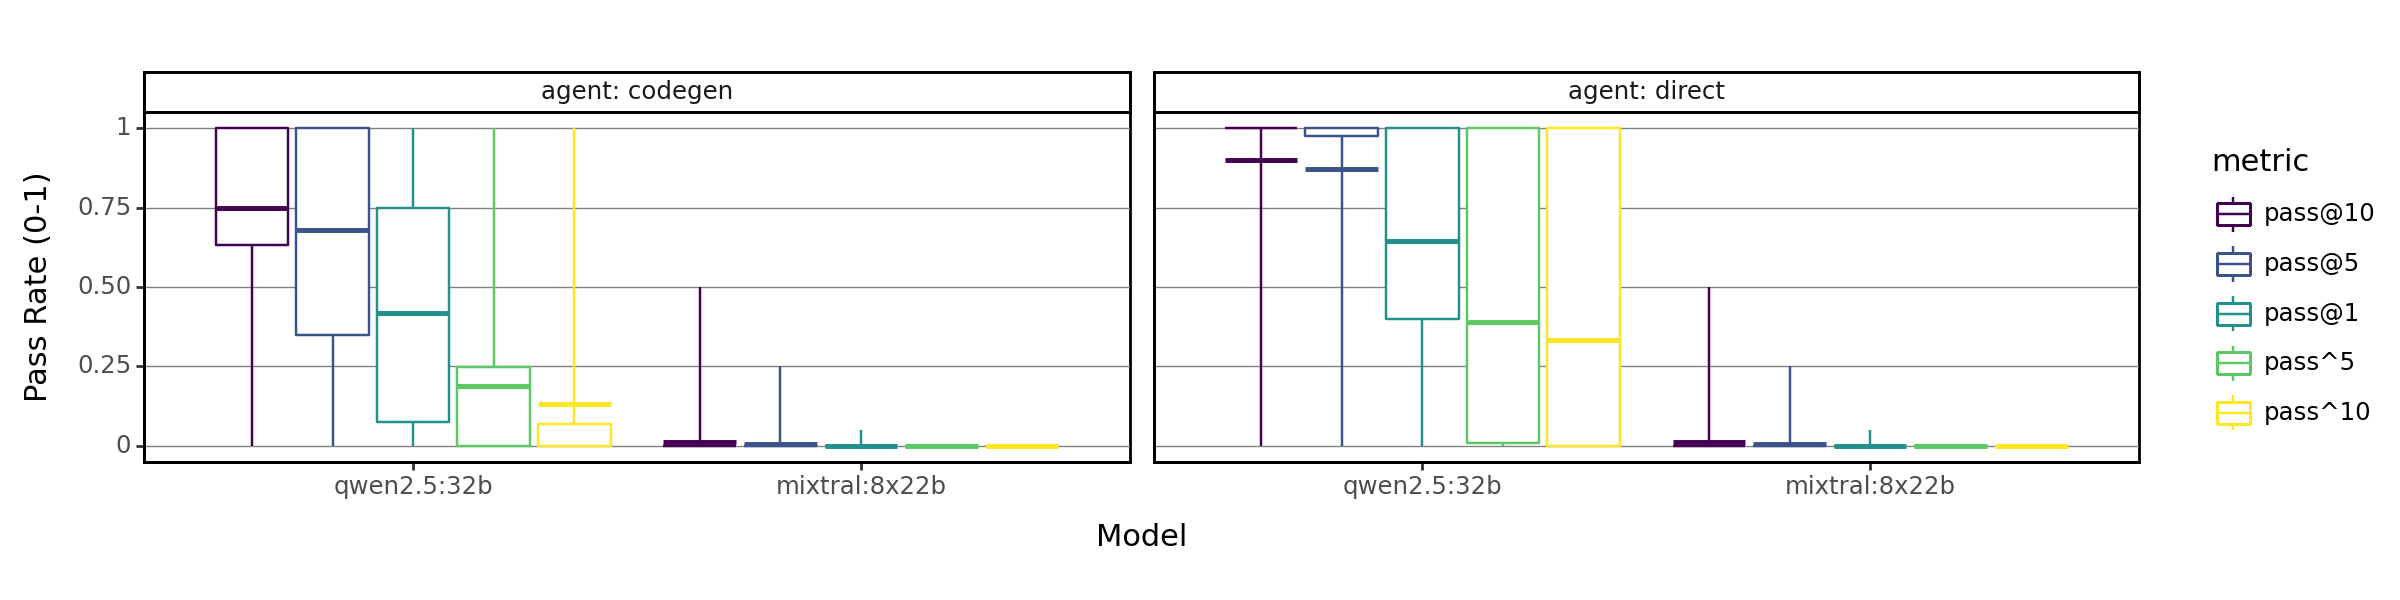

<Figure Size: (1200 x 300)>

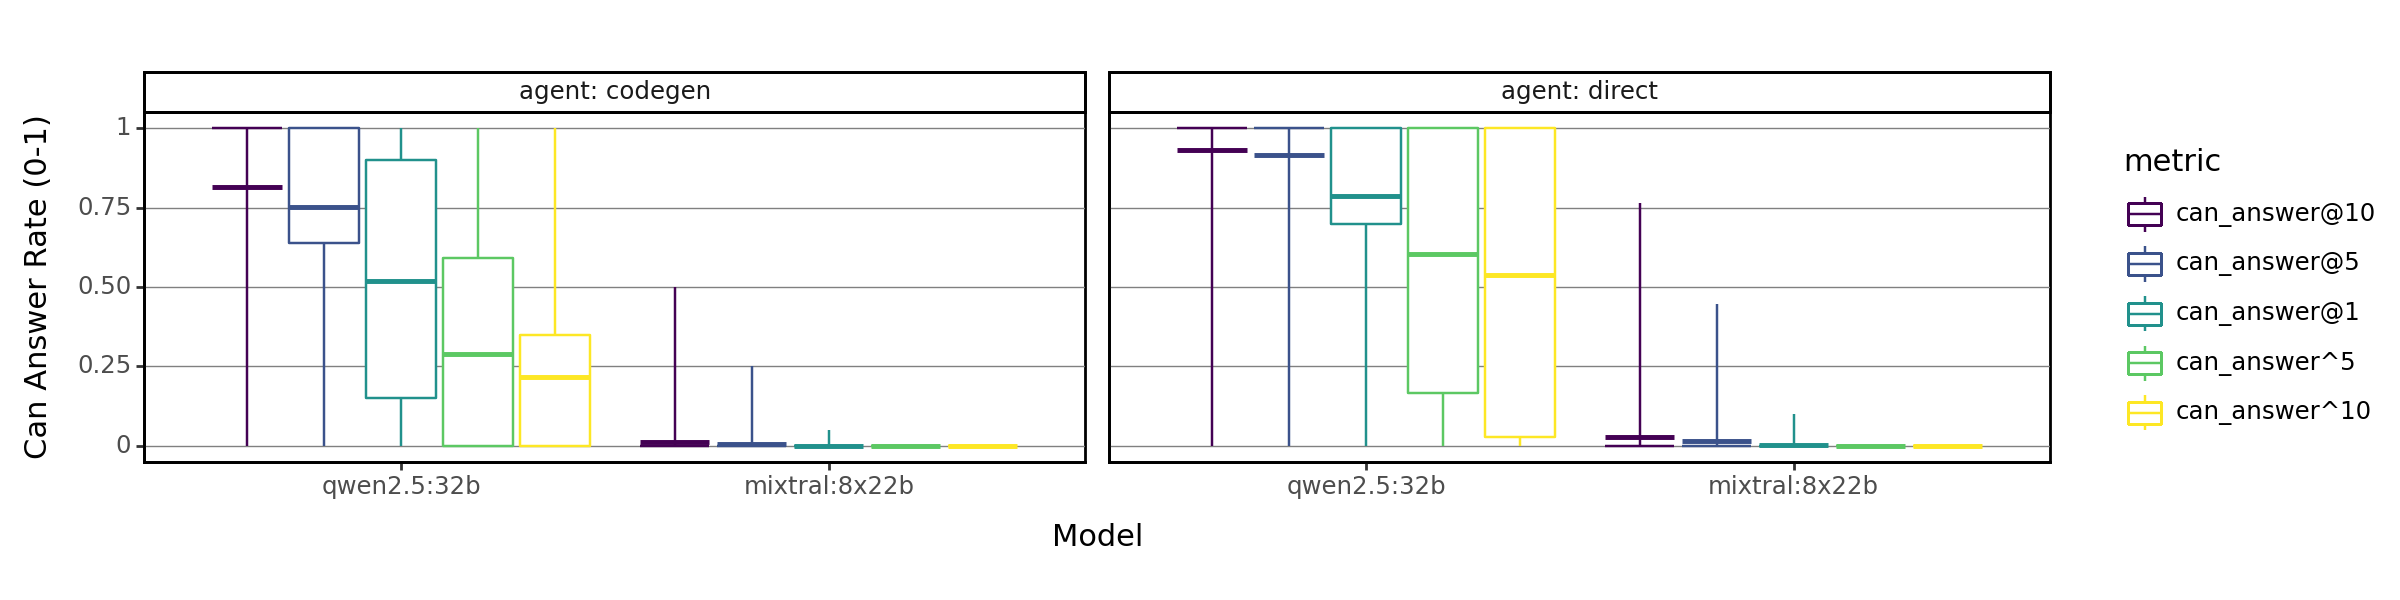

<Figure Size: (1200 x 300)>

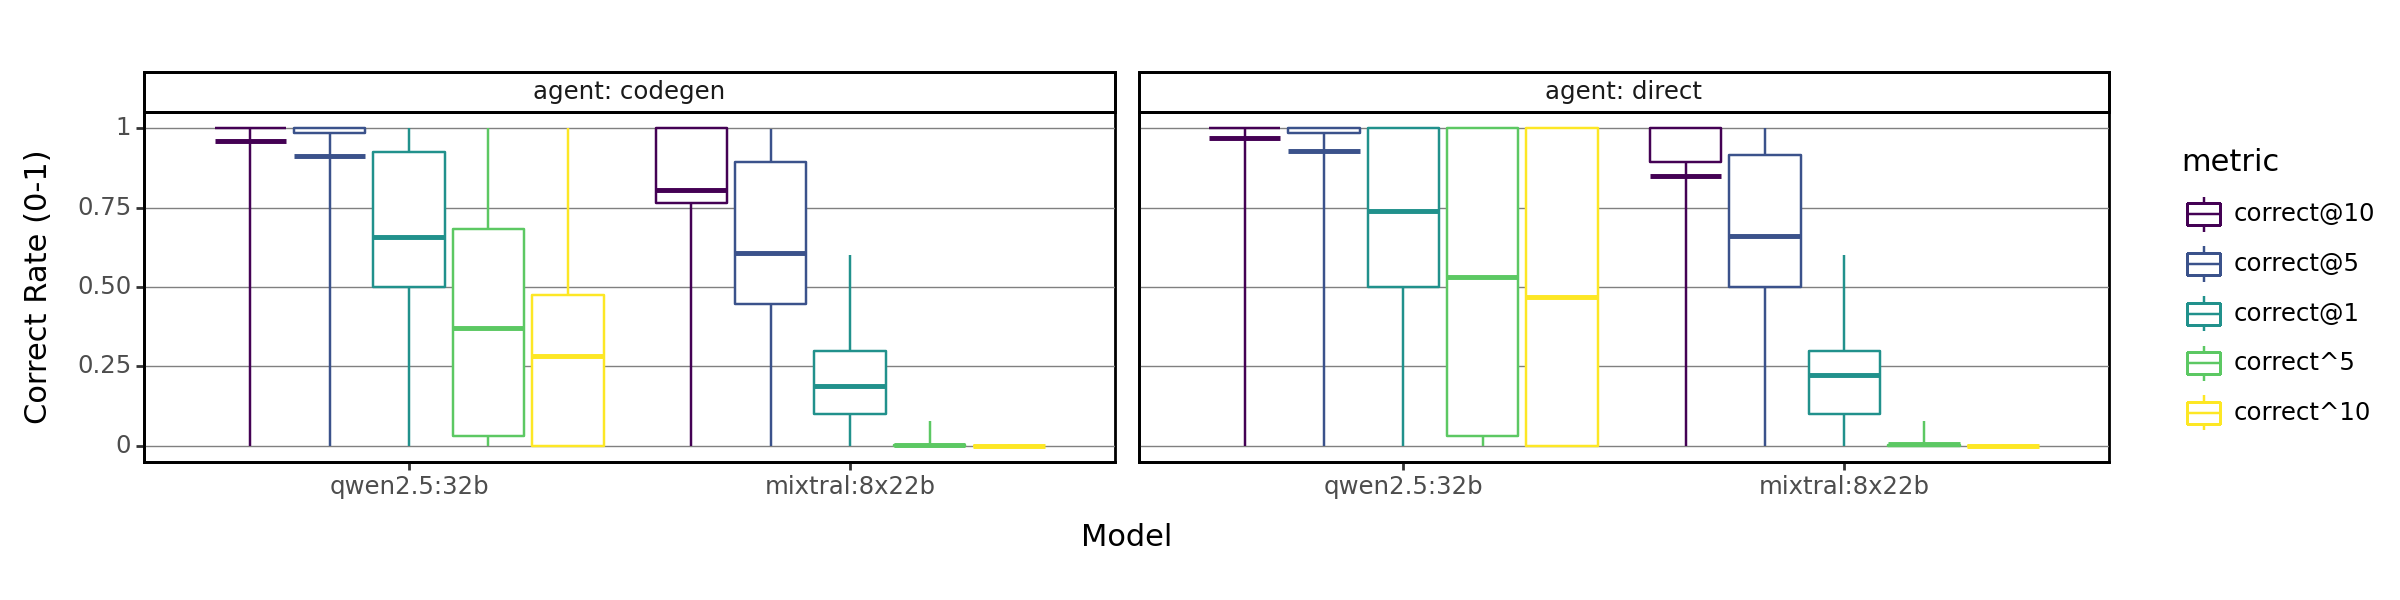

<Figure Size: (1200 x 300)>

In [7]:
_pass_metrics = [
    "pass@10",
    "pass@5",
    "pass@1",
    "pass^5",
    "pass^10",
]
_can_answer_metrics = [
    "can_answer@10",
    "can_answer@5",
    "can_answer@1",
    "can_answer^5",
    "can_answer^10",
]
_correct_metrics = [
    "correct@10",
    "correct@5",
    "correct@1",
    "correct^5",
    "correct^10",
]

_g0 = draw_metrics(raw_grouped,_pass_metrics, ylabel="Pass Rate (0-1)", height=3, facet=["agent"])
_g1 = draw_metrics(raw_grouped, _can_answer_metrics, ylabel="Can Answer Rate (0-1)", height=3, facet=["agent"])
_g2 = draw_metrics(raw_grouped, _correct_metrics, ylabel="Correct Rate (0-1)", height=3, facet=["agent"])
display(_g0)
display(_g1)
display(_g2)
_g0.save(f"{OUTPUT_PATH}/moe_pass.png", bbox_inches="tight", dpi=300)
_g1.save(f"{OUTPUT_PATH}/moe_can_answer.png", bbox_inches="tight", dpi=300)
_g2.save(f"{OUTPUT_PATH}/moe_correct.png", bbox_inches="tight", dpi=300)
# _g.savefig(f"{OUTPUT_PATH}/reasoning_performance_breakdown.png")

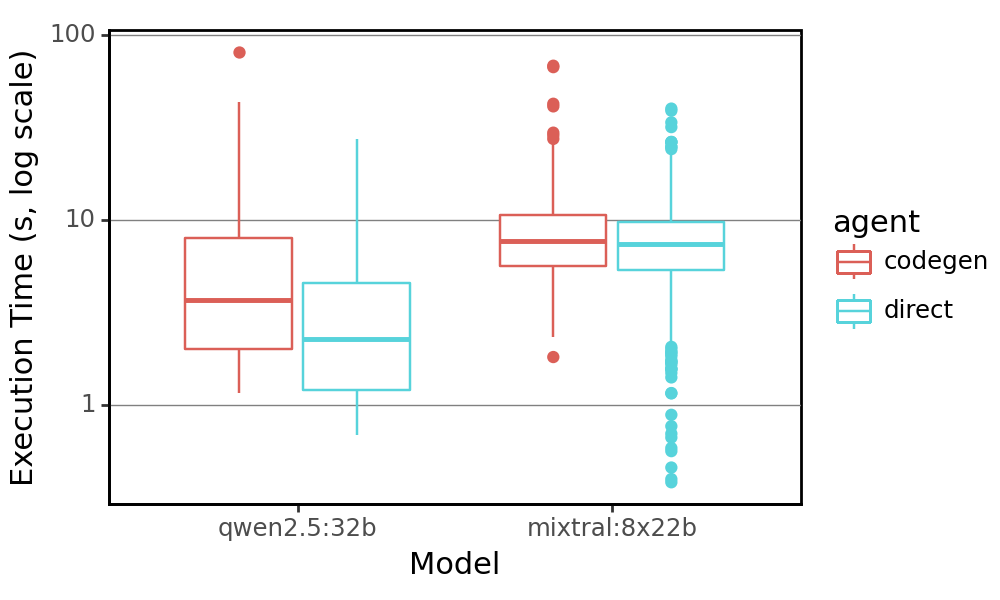

<Figure Size: (500 x 300)>

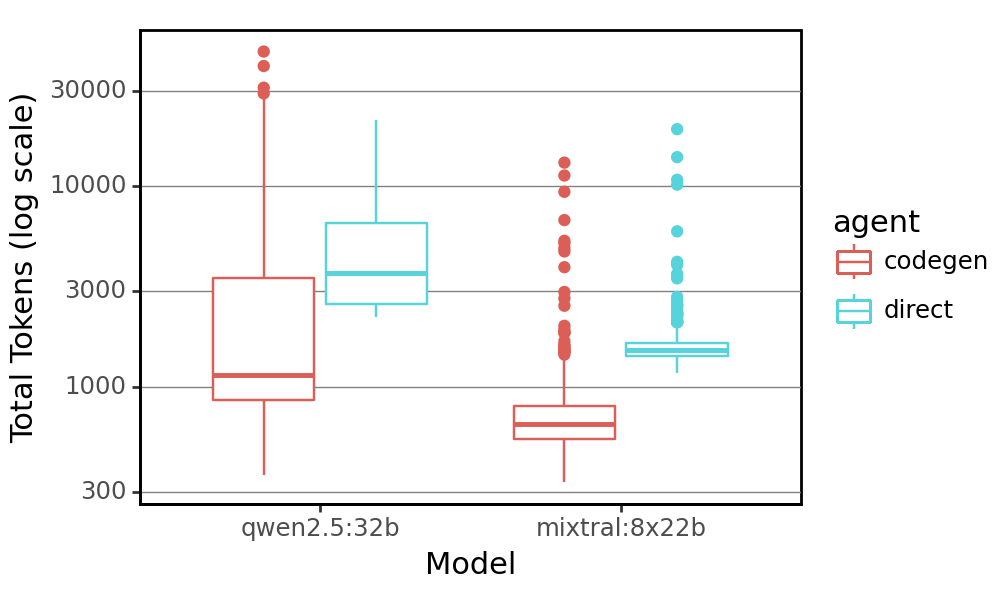

<Figure Size: (500 x 300)>

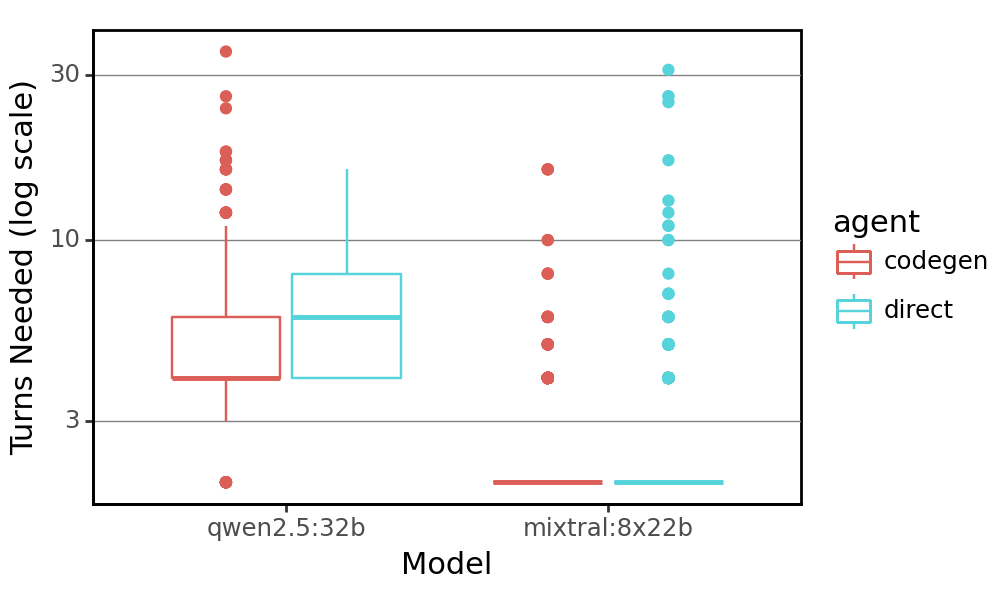

<Figure Size: (500 x 300)>

In [8]:
_g1 = (
    ggplot(df, aes(x="model", y="execution_time", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    # + facet_wrap(["agent"], labeller="label_both")
    + scale_y_log10()
    + labs(
        x="Model",
        y="Execution Time (s, log scale)",
        # title="Execution Time",
    )
    + my_theme(5, 3)
)
display(_g1)

_g2 = (
    ggplot(df, aes(x="model", y="total_tokens", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    + scale_y_log10()
    # + facet_wrap(["agent"], labeller="label_both")
    + labs(
        x="Model",
        y="Total Tokens (log scale)",
        # title="Total Tokens",
    )
    + my_theme(5, 3)
)
display(_g2)

_g3 = (
    ggplot(df, aes(x="model", y="num_messages", color="agent"))
    # + geom_bar(stat="identity", position="dodge")
    + pn.geom_boxplot(position="dodge2")
    + scale_y_log10()
    # + facet_wrap(["agent"], labeller="label_both")
    + labs(
        x="Model",
        y="Turns Needed (log scale)",
        # title="Total Tokens",
    )
    + my_theme(5, 3)
)
display(_g3)

_g1.draw().savefig(f"{OUTPUT_PATH}/moe_execution_time.png", bbox_inches="tight", dpi=300)
_g2.draw().savefig(f"{OUTPUT_PATH}/moe_total_tokens.png", bbox_inches="tight", dpi=300)
_g3.draw().savefig(f"{OUTPUT_PATH}/moe_num_messages.png", bbox_inches="tight", dpi=300)